# Data Quality und Data Bias

<div style="padding: 5px; border: 5px solid #a10000ff;">

**Hinweis:** In den Codezellen sind jeweils einige Codeteile nicht programmiert. Diesen Code müssen Sie ergänzen. Die jeweiligen Stellen sind mit einem Kommentar und dem Keyword **TODO** vermerkt und z.T. Stellen mit ... markiert.

Ausserdem gibt es einige assert Statements. Diese geben einen Fehler aus, sollte etwas bei Ihrer Programmierung nicht korrekt sein.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import os
import random
import PIL.Image as Image

## Datenqualität

Wenn wir ein Modell trainieren, ist es wichtig, dass die Daten von guter Qualität sind. Schlechte Datenqualität kann zu schlechten Modellen führen, die nicht gut generalisieren und somit schlechte Vorhersagen machen. Es gibt verschiedene Kriterien, die die Qualität der Daten bestimmen. Sie sollten Ihren Datensatz stets auf diese Kriterien prüfen, bevor Sie mit dem Training eines Modells beginnen.

**Datenqualitätskriterien:**
- **Aktualität&Relevanz**: Alle Daten sind aktuell und relevant für das Problem, das gelöst werden soll.
- **Konsistenz**: Alle Daten sind im gleichen Format (z.B. gleiche Bildgrössen, gleiche Pixelwerte, keine Mischung von Datentypen z.B. Integer und Datum in selbem Feld)
- **Vollständigkeit**: Alle notwendigen Daten sind vorhanden, es gibt keine fehlenden Werte.
- **Einzigartigkeit**: Es gibt keine Duplikate in den Daten, die somit die Trainingsdaten verzerren könnten.
- **Richtigkeit**: Alle Daten sind korrekt und entsprechen der Realität (z.B. keine falschen Labels, keine fehlerhaften Werte)




In diesem Notebook werden wir ein Dataset nutzen, das viele Fehler beinhaltet, um die Datenqualität zu prüfen.

## Dataset

Sie übernehmen in diesem Notebook die Rolle eines Data Scientists und haben die Aufgabe erhalten, ein Modell zu trainieren, das vorhersagen kann, wie viel Gehalt eine Person verdient.
Sie haben die Daten aller Mitarbeiter*innen des Unternehmens von der Peronalabteilung (Human Resources (HR)) erhalten. Ihre Aufgabe ist es nun die Daten für das Training eines Modells vorzubereiten.
*Dataset Quelle: https://github.com/eyowhite/Messy-dataset/blob/main/messy_HR_data.csv*


In dem Dataset gibt es 1000 Data Samples und folgende Features:

| Feature | Beschreibung |
|---------|--------------|
| Name | Name der Person |
| Age | Alter der Person in Jahren |
| Salary | Gehalt der Person (Target) |
| Gender | Geschlecht der Person |
| Department | Abteilung, in der die Person arbeitet |
| Position | Positionsbezeichnung der Person |
| Joining Date | Datum, an dem die Person dem Unternehmen beigetreten ist |
| Performance Score | Leistungsbewertung der Person |
| Email | Email-Adresse der Person |
| Phone Number | Telefonnummer der Person |

### Daten laden
Zuerst laden wir die Daten in ein Pandas DataFrame, um sie zu analysieren und zu prüfen.

In [2]:
data = pd.read_csv("datasets/messy_HR_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               1001 non-null   object
 1   Age                842 non-null    object
 2   Salary             1001 non-null   object
 3   Gender             1001 non-null   object
 4   Department         1001 non-null   object
 5   Position           1001 non-null   object
 6   Joining Date       1001 non-null   object
 7   Performance Score  1001 non-null   object
 8   Email              613 non-null    object
 9   Phone Number       816 non-null    object
dtypes: object(10)
memory usage: 78.3+ KB


## Datenqualität prüfen

### Aktualität & Relevanz

Wir prüfen zuerst ob die Daten aktuell sind und welche Features relevant sind für die Vorhersage des Gehalts. Es könnte sein, dass einige Features veraltet sind oder nicht relevant für die Vorhersage des Gehalts sind. 
In diesem Fall sollten diese Features entfernt werden, um nur die relevanten Informationen für das Training des Modells zu behalten.
Die Aktualität der Daten lassen wir hier aussen vor, da wir davon ausgehen, dass Sie die Daten gerade erst erhalten haben und somit aktuell sind.

Wir machen diesen Schritt zuerst, da wir somit irrelevante Daten entfernen können und diese nicht unnötigerweise korrigieren, obwohl sie für die Vorhersage des Gehalts nicht relevant sind.


#### Aufgabe 1

1. Welche Features sind relevant für die Vorhersage des Gehalts? Welche Features könnten irrelevant sein?
> Irrelevant sind sicherlich Features wie Name, E-Mail un dTelefonnummer. Dies sollte keinen Einfluss auf das Gehalt haben. Eine wichtige Entscheidung ist auch, das Feature "Gender" zu betrachten. Es könnte sein, dass es einen historischen und diskriminierenden Bias gibt und Frauen im Durchschnitt weniger verdienen als Männer. Es wäre deshalb ratsam dieses Feature zu entfernen, um den Bias nicht weiter zu verstärken.

2. Welchen Einfluss hat Ihre Entscheidung auf das Modell? Welches Risiko besteht, wenn Sie ihre Entscheidung nicht gut treffen?
> Wenn Sie irrelevante Features behalten, könnte das Modell lernen, dass diese Features einen Einfluss auf das Gehalt haben, obwohl dies nicht der Fall ist. Dies könnte zu einem schlechten Modell führen, das nicht gut generalisiert und somit schlechte Vorhersagen macht. Wenn Sie relevante Features entfernen, könnte das Modell wichtige Informationen verlieren, die für die Vorhersage des Gehalts wichtig sind. Dies könnte ebenfalls zu einem schlechten Modell führen. Es ist deshalb wichtig, dass Sie entweder selbst die nötigen Fachkentnisse haben, um die Relevanz der Features zu beurteilen oder dass Sie mit Expert*innen zusammenarbeiten, die Ihnen dabei helfen können.

#### Irrelevante Features entfernen

Wir entfernen folgende Features: Name, Email, PhoneNumber und Gender.

In [4]:
data = data.drop(columns=["Name", "Email", "Phone Number", "Gender"])

### Konsistenz
Nachdem wir die irrelevanten Features entfernt haben, prüfen wir nun ob alle Daten im gleichen Format vorliegen. Dies gehen wir als nächste an, da wir somit die Daten korrigieren können, welche wir eventuell nutzen um die Vollständigkeit herzustellen. Beispiel: 
Wir haben gewisse Daten nicht, aber wir wollen diese z.B. mit dem Mittelwert der Daten im selben Feature ersetzen. Es ist wichtig, dass alle Daten im selben Format vorliegen, damit wir diese korrekt korrigieren können.

#### Aufgabe 2
1. Prüfen Sie die Konsistenz der Daten. Gibt es Daten die nicht im gleichen Format vorliegen? Notieren Sie hier die Inkonsistenzen, die Sie gefunden haben. Die Code Zellen weiter unten helfen Ihnen dabei die Konsistenz der Daten zu prüfen. (Zu NaN Werten kommen wir im  Abschnitt Vollständigkeit noch. Sie können diese hier schon notieren, müssen sie aber nicht korrigeieren, da wir diese erst im Abschnitt Vollständigkeit korrigieren werden.)

> - Age hat NaN und thirty als String
> - Salary: hat NAN und "SIXTY THOUSAND" als String
> - Joining Date hat fünf verschiedene Datumsformate definiert

2. Wie könnten Sie diese Inkonsistenzen korrigieren? Überlegen Sie sich mögliche Lösungen, um die Daten in ein konsistentes Format zu bringen.
> Age: "thirty" könnte durch 30 ersetzt werden. Die NaN Werte ignorieren wir hier noch.
> Salary: "SIXTY THOUSAND" könnte durch 60000 ersetzt werden. Die NaN Werte ignorieren wir hier noch.
> Joining Date: Alle Daten in dasselbe Datumsformat bringen, z.B. "YYYY-MM-DD".



#### Stichprobe für ein besseres Verständnis der Daten

Eine erste Stichprobe zeigt bereits auf, dass es einige Datenqualitätsprobleme gibt. Notieren Sie sich diese in der Aufgabe 2.

In [5]:
data.head()

,Age,Salary,Department,Position,Joining Date,Performance Score
0,25,50000,HR,Manager,"April 5, 2018",D
1,NaN,65000,Finance,Director,2020/02/20,F
2,35,SIXTY THOUSAND,Sales,Director,01/15/2020,C
3,NaN,50000,IT,Manager,"April 5, 2018",A
4,NaN,NAN,Finance,Manager,01/15/2020,F


#### Datentyp prüfen

In der Info Ausgabe sehen wir, dass alle Features im "object" Datentyp vorliegen, was heisst sie sind als String gespeichert. Auch die numerischen Werte wie Age und Salary sind als String gespeichert.
Dies ist ein erster Indikator für eine Inkonsistenz.
Ausserdem sehen wir, für später zur Vollsätndigkeit, dass es bei Age 158 fehlende Werte gibt.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                842 non-null    object
 1   Salary             1001 non-null   object
 2   Department         1001 non-null   object
 3   Position           1001 non-null   object
 4   Joining Date       1001 non-null   object
 5   Performance Score  1001 non-null   object
dtypes: object(6)
memory usage: 47.1+ KB


#### Einzigartige Werte prüfen

Machnmal kann es sein, dass es in einem Feature viele Werte gibt, welche gleich falsch erfasst wurden. Wir schauen uns deshalb die einzigartigen Werte und deren Häufigkeit an, um zu prüfen, ob es solche Inkonsistenzen gibt.

In [7]:
print("-"*20, "Age", "-"*20)
print(data["Age"].value_counts())

print("-"*20, "Salary", "-"*20)
print(data["Salary"].value_counts())

print("-"*20, "Department", "-"*20)
print(data["Department"].value_counts())

print("-"*20, "Position", "-"*20)
print(data["Position"].value_counts())


print("-"*20, "Joining Date", "-"*20)
print(data["Joining Date"].value_counts())

print("-"*20, "Performance Score", "-"*20)
print(data["Performance Score"].value_counts())

-------------------- Age --------------------
Age
thirty    176
25        173
40        169
35        163
50        161
Name: count, dtype: int64
-------------------- Salary --------------------
Salary
65000             184
70000             173
55000             171
 NAN              167
50000             163
SIXTY THOUSAND    143
Name: count, dtype: int64
-------------------- Department --------------------
Department
Finance      218
Sales        202
HR           199
IT           195
Marketing    187
Name: count, dtype: int64
-------------------- Position --------------------
Position
Assistant    213
Director     206
Clerk        201
Analyst      195
Manager      186
Name: count, dtype: int64
-------------------- Joining Date --------------------
Joining Date
2020/02/20       232
2019.12.01       204
01/15/2020       197
April 5, 2018    188
03-25-2019       180
Name: count, dtype: int64
-------------------- Performance Score --------------------
Performance Score
B    224
F    204

#### Korrekturen anbringen

In [8]:
# Age: Thirty mit 30 ersetzen
data["Age"] = data["Age"].replace("thirty", "30")

# Salary: "SIXTY THOUSAND" mit 60000 ersetzen
data["Salary"] = data["Salary"].replace("SIXTY THOUSAND", "60000")


# Joining Date harmonisieren (gleiche Datumsformate verwenden)
#2020/02/20     
# 2019.12.01    
# 01/15/2020    
# April 5, 2018 
# 03-25-2019    
data["Joining Date"] = data["Joining Date"].replace("2020/02/20", "2020-02-20")
data["Joining Date"] = data["Joining Date"].replace("2019.12.01", "2019-12-01")
data["Joining Date"] = data["Joining Date"].replace("01/15/2020", "2020-01-15")
data["Joining Date"] = data["Joining Date"].replace("April 5, 2018", "2018-04-05")
data["Joining Date"] = data["Joining Date"].replace("03-25-2019", "2019-03-25")


### Vollständigkeit
Nachdem Sie die irrelevanten Features entfernt haben, sollten Sie die Vollständigkeit der Daten prüfen. Es könnte sein, dass es fehlende Werte gibt, die das Training des Modells beeinträchtigen könnten. Es ist wichtig, dass Sie diese fehlenden Werte entweder entfernen oder imputeieren, um sicherzustellen, dass das Modell gut trainiert werden kann.

**NaN**

NaN steht für "Not a Number" und ist ein spezieller Wert, der in Pandas verwendet wird, um fehlende Werte darzustellen.

In den Daten werden fehlende Werte meist mit "NAN" oder "NaN" oder "nan" oder "None" oder "none" oder "NULL" oder "null" oder einem leeren String "" dargestellt. Das Problem ist, dass alle Werte ausser NaN als String erkannt werden und somit nicht als fehlende Werte ausgewiesen werden. Es ist wichtig, dass Sie alle diese Werte als fehlende Werte markieren, damit Sie diese korrekt behandeln können. 

**Fehlende Werte behandeln**

Es gibt verschiedene Möglichkeiten, wie Sie mit fehlenden Werten umgehen können.
- Entfernen der Zeilen mit fehlenden Werten
- Auffüllen der fehlenden Werte mit dem Mittelwert oder Median der vorhandenen Werte
- Auffüllen der fehlenden Werte mit einem speziellen Wert, z.B. "Unknown" oder -1

Es ist wichtig, dass Sie die Methode wählen, die am besten zu Ihren Daten und Ihrem Problem passt. Wenn Sie z.B. viele fehlende Werte haben, könnte es sinnvoll sein, diese zu entfernen. Wenn Sie nur wenige fehlende Werte haben, könnte es sinnvoller sein, diese aufzufüllen, um mehr Daten für das Training des Modells zu haben. 

#### Frage 3:

1. Welche Spalten beinhalten NaN Werte? Wie viele NaN Werte gibt es in diesen Spalten?
> - Age hat 159 NaN Werte
> - Salary hat 167 " NAN " Werte. Diese müssen wir noch korrekt als NaN markieren, da sie aktuell als String vorliegen. (Sichtbar in den Value Counts aus Frage 2)

2. Wie würden Sie mit den fehlenden Age Werten umgehen? Würden Sie diese entfernen oder auffüllen? Begründen Sie Ihre Entscheidung.
> Es kommt darauf an, wie viele fehlende Werte es gibt und wie wichtig das Feature Age für die Vorhersage des Gehalts ist. Das Alter kann eine Rolle beim Gehalt spielen aber da mehr als 10% der Werte fehlen, versuchen wir die Daten aufzufüllen und würden danach beobachten wie das Modell performt.

3. Wie würden Sie mit den fehlenden Salary Werten umgehen? Würden Sie diese entfernen oder auffüllen? Begründen Sie Ihre Entscheidung.
> Da es die Target-Variable ist, sollte man die Zeilen mit fehlenden Salary Werten entfernen, da es schwierig ist, diese Werte realistisch aufzufüllen und es wichtig ist, dass das Modell mit vollständigen Daten trainiert wird.

4. Welchen Einfluss hat Ihre Entscheidung auf das Modell? Welches Risiko besteht, wenn Sie ihre Entscheidung nicht gut treffen?
> Wenn Sie zu viele fehlende Werte entfernen, könnte das Modell nicht genug Daten zum Trainieren haben und somit schlecht generalisieren. Wenn Sie zu viele fehlende Werte auffüllen, könnte das Modell mit falschen Daten trainiert werden und somit schlechte Vorhersagen machen. Es ist deshalb wichtig, dass Sie die Methode wählen, die am besten zu Ihren Daten und Ihrem Problem passt.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                842 non-null    object
 1   Salary             1001 non-null   object
 2   Department         1001 non-null   object
 3   Position           1001 non-null   object
 4   Joining Date       1001 non-null   object
 5   Performance Score  1001 non-null   object
dtypes: object(6)
memory usage: 47.1+ KB


#### NaN Werte korrekt markieren und fehlende Werte behandeln

Wir ersetzen zuerst die " NAN " Werte in der Salary Spalte durch NaN Werte, damit wir diese korrekt als fehlende Werte markieren können.
Wir entfernen nun die Zeilen mit fehlenden Salary Werten und füllen die fehlenden Age Werte mit dem Mittelwert der vorhandenen Age Werte auf. Danach prüfen wir, ob es noch fehlende Werte gibt.

In [10]:
# " NAN" Werte in Salary Spalte durch NaN Werte ersetzen
data["Salary"] = data["Salary"].replace(" NAN ", np.nan)

# Data Samples mit fehlenden Salary Werten entfernen
data = data.dropna(subset=["Salary"])
# Fehlende Age Werte mit Mittelwert auffüllen
data["Age"] = data["Age"].fillna(data["Age"].astype(float).mean())


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 834 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                834 non-null    object
 1   Salary             834 non-null    object
 2   Department         834 non-null    object
 3   Position           834 non-null    object
 4   Joining Date       834 non-null    object
 5   Performance Score  834 non-null    object
dtypes: object(6)
memory usage: 45.6+ KB


### Einzigartigkeit

Nachdem wir nun die fehlenden Werte behandelt haben und auch die Inkonsistenzen korrigiert haben, können wir prüfen ob es Duplikate in den Daten gibt. 
Es ist wichtig zuerst die Daten konsistent zu machen und die fehlenden Werde zu behandeln, bevor wir die Einzigartigkeit prüfen, da es sonst sein könnte, dass wir Duplikate übersehen, welche durch die Inkonsistenzen oder fehlenden Werte verursacht werden

#### Aufgabe 4:

1. Gibt es Duplikate in den Daten? Wie viele Duplikate gibt es?
> Es gibt 35 mehrfach vorkommende Einträge, welche als Duplikate markiert werden.

2. Welchen Einfluss haben Duplikate auf das Modell? Welches Risiko besteht, wenn Sie Duplikate in den Daten belassen?
> Duplikate können das Modell verzerren, da sie bestimmte Datenpunkte überrepräsentieren können.

3. Sind alle Duplikate auch wirklich Duplikate oder könnte es sein, dass es sich um unterschiedliche Personen handelt, welche zufällig die gleichen Werte in allen Features haben? Wie könnten Sie dies prüfen?
> Es könnte sein, dass es sich um unterschiedliche Personen handelt, welche zufällig die gleichen Werte in allen Features haben. Um dies zu prüfen, könnten Sie z.B. die E-Mail Adressen oder Telefonnummern der Personen im originalen Dataset vergleichen, um zu sehen, ob es sich um dieselbe Person handelt.

In [12]:
# Daten auf Duplikate prüfen
duplicates = data.duplicated(keep=False)  # keep=False markiert alle Duplikate, so dass alle mehrfachen Einträge als Duplikate ausgegeben werden

print(f"Anzahl Duplikate: {duplicates.sum()}\n")

print(data[duplicates])

Anzahl Duplikate: 35

           Age Salary Department   Position Joining Date Performance Score
21          25  50000         IT   Director   2018-04-05                 F
29          25  50000         IT   Director   2018-04-05                 F
30          25  50000         IT   Director   2018-04-05                 F
113  35.664781  70000         HR    Manager   2020-02-20                 B
137         25  50000         IT    Analyst   2019-03-25                 D
171         40  60000         HR   Director   2019-12-01                 F
234  35.664781  70000         HR    Manager   2020-02-20                 B
237         25  65000      Sales    Analyst   2020-01-15                 F
240         25  65000      Sales    Analyst   2020-01-15                 F
257         40  50000    Finance  Assistant   2018-04-05                 D
269         40  50000    Finance  Assistant   2018-04-05                 D
303         35  65000  Marketing    Analyst   2019-12-01                 F
339

### Richtigkeit

Zuletzt wollen wir nun noch die Richtigkeit der Daten prüfen. Es könnte sein, dass es falsche Werte gibt, welche das Training des Modells beeinträchtigen könnten. Es ist wichtig, dass Sie diese falschen Werte entweder entfernen oder korrigieren, um sicherzustellen, dass das Modell gut trainiert werden kann.

Wir wenden eine Plausibilitätsprüfung an, um zu prüfen, ob die Werte in den Daten realistisch sind (plausibel). Beispiel: Es könnte sein, dass es Personen gibt, welche 200 Jahre alt sind oder 10 Millionen Gehalt verdienen. Diese Werte sind nicht realistisch und sollten entweder entfernt oder korrigiert werden, um sicherzustellen, dass das Modell mit realistischen Daten trainiert wird.

Wir nutzen Histogramme für die Numerischen Werte um die Verteilung der Werte in den Daten zu visualisieren und somit unplausible Werte zu identifizieren.

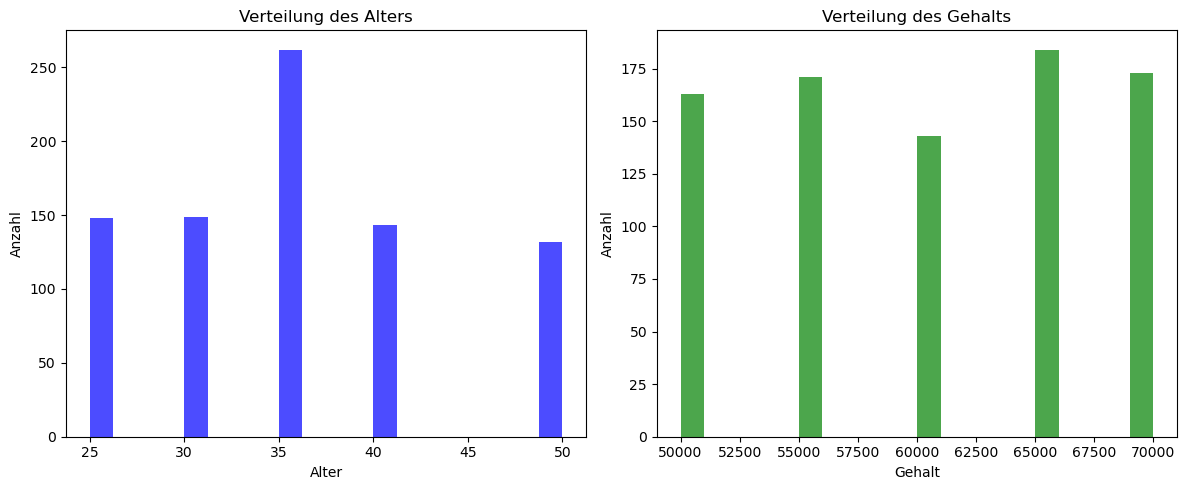

In [13]:
# Histogramme der numerischen Werte erstellen, um unplausible Werte zu identifizieren
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(data["Age"].astype(float), bins=20, color='blue', alpha=0.7)
plt.title("Verteilung des Alters")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.subplot(1, 2, 2)
plt.hist(data["Salary"].astype(float), bins=20, color='green', alpha=0.7)
plt.title("Verteilung des Gehalts")
plt.xlabel("Gehalt")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

#### Aufgabe 5:

1. Gibt es unplausible Werte in den Daten? Welche unplausiblen Werte gibt es?
> Nein, es scheint keine unplausiblen Werte zu geben, da die Verteilung der Werte in den Daten realistisch aussieht.

2. Wie würde ein Histogramm aussehen, welches unplausible Werte enthält?
> Ein Histogramm mit unplausiblen Werten könnte z.B. eine sehr breite Verteilung haben, welche unrealistische Werte enthält, wie z.B. Personen, welche 200 Jahre alt sind oder 10 Millionen Gehalt verdienen. Es könnte auch sein, dass es Ausreisser gibt, welche weit von der restlichen Verteilung entfernt sind.

## Bias

Nebst den grundlegenden Datenqualitätskriterien, ist es auch wichtig, dass Sie die Daten auf einen Bias prüfen. Ein Bias in den Daten kann dazu führen, dass das Modell diskriminierende Vorhersagen macht und somit bestimmte Gruppen von Menschen benachteiligt. Es ist wichtig, dass Sie die Daten auf einen Bias prüfen und diesen beseitigen, um sicherzustellen, dass das Modell faire Vorhersagen macht.

### Aufgabe 6:
Für den Einsatzzweck das Gehalt einer Person vorherzusagen gibt es durchaus auch ethische Überlegungen, welche berücksichtigt werden sollten.
Gerade ein Data-Bias könnte hier vorhanden sein.

1. Überlegen Sie für folgende Data-Bias Kategorien wie diese in diesem Einsatzzweck und Beispiel vorhanden sein könnten:
- Selection Bias
- Measurement Bias
- Historical Bias
- Survivorship Bias
- Confirmation Bias

> - Selection Bias: Es könnte sein, dass die Daten, welche wir erhalten haben, nicht repräsentativ für die gesamte Population der Mitarbeiter*innen des Unternehmens sind. Beispiel: Es könnte sein, dass die Daten nur von einer bestimmten Abteilung oder eine bestimmten Filiale des Unternehmens stammen. 
> - Measurement Bias: Es könnte sein, dass die Daten falsch gemessen wurden. Beispiel: Es könnte sein, dass das Gehalt falsch erfasst wurde, z.B durch eine falsche Umrechnung von Währungen.
> - Historical Bias: Es könnte sein, dass die Daten einen historischen Bias enthalten, z.B. dass Frauen im Durchschnitt weniger verdienen als Männer, was auf eine historische Diskriminierung zurückzuführen ist.
> - Survivorship Bias: Es könnte sein, dass die Daten nur von den Mitarbeiter*innen stammen, welche noch im Unternehmen sind, und somit die Mitarbeiter*innen, welche das Unternehmen verlassen haben, nicht berücksichtigt werden. Dies könnte zu einem Bias führen, da die Mitarbeiter*innen, welche das Unternehmen verlassen haben, möglicherweise andere Gehälter hatten als die Mitarbeiter*innen, welche noch im Unternehmen sind. Eventuell haben die Mitarbeiter*innen das Unternehmen aufgrund des Gehalts verlassen. 
> - Confirmation Bias: Es könnte sein, dass die Daten einen Confirmation Bias enthalten, z.B. dass die Daten so ausgewählt wurden, dass sie eine bestimmte Hypothese bestätigen, z.B. dass die IT-Abteilung im Durchschnitt mehr verdient als die Sales-Abteilung. 